Домашнее задание по теме «Снижение размерности. Алгоритм PCA»

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

Загружаем данные

In [6]:
train_df=pd.read_csv('penguins.csv')

In [7]:
pd.options.display.float_format = '{:,.2f}'.format
train_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",MALE
1,39.50,17.40,186.00,"3,800.00",FEMALE
2,40.30,18.00,195.00,"3,250.00",FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.70,19.30,193.00,"3,450.00",FEMALE


In [52]:
train_df.info(memory_usage=True) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Можно заметить, что в таблице есть пропуски. Оставим их для EDA, а для обучения модели заполним их.

In [7]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58
sex,2.62


Выделяем категориальные и числовые столбцы и создаем подтаблицы для EDA.

In [8]:
category_col = train_df.select_dtypes(include=['object']).columns.tolist()
category_col

['sex']

In [9]:
train_df_cat = train_df[category_col]
number_col = train_df.select_dtypes(include=['number']).columns.tolist()
train_df_num = train_df[number_col]

Заполнение пропусков

In [10]:
train_df = train_df.apply(lambda x: x.fillna(x.mode()[0]))

In [56]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.00
culmen_depth_mm,0.00
flipper_length_mm,0.00
body_mass_g,0.00
sex,0.00


Для кодирования категориальных переменных будем использовать TargetOrdinalEncoding

# EDA

Для числовых столбцов:

In [64]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_num.isnull().sum() * 100 / len(train_df_num.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
culmen_length_mm,0.58
culmen_depth_mm,0.58
flipper_length_mm,0.58
body_mass_g,0.58


In [65]:
#Находим максимальные и минимальные значения
min_max_df = pd.DataFrame({'Максимальное значение': train_df_num.max(), 'Минимальное значение': train_df_num.min()})

min_max_df

,Максимальное значение,Минимальное значение
culmen_length_mm,59.60,32.10
culmen_depth_mm,21.50,13.10
flipper_length_mm,"5,000.00",-132.00
body_mass_g,"6,300.00","2,700.00"


In [66]:
#Находим средние значения
mean_df = pd.DataFrame({'Среднее значение': train_df_num.mean()})

mean_df

,Среднее значение
culmen_length_mm,43.92
culmen_depth_mm,17.15
flipper_length_mm,214.01
body_mass_g,"4,201.75"


In [67]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df_num.median()})

median_df

,Медиана
culmen_length_mm,44.45
culmen_depth_mm,17.30
flipper_length_mm,197.00
body_mass_g,"4,050.00"


In [68]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df_num.var()})

var_df

,Диспрерсия
culmen_length_mm,29.81
culmen_depth_mm,3.90
flipper_length_mm,"67,890.50"
body_mass_g,"643,131.08"


In [69]:
#Находим квантиль 0.1 и 0.9
quantile_df = pd.DataFrame({'Квантиль 0.1': train_df_num.quantile(0.1), 'Квантиль 0.9': train_df_num.quantile(0.9)})

quantile_df

,Квантиль 0.1,Квантиль 0.9
culmen_length_mm,36.60,50.80
culmen_depth_mm,14.30,19.50
flipper_length_mm,185.00,221.00
body_mass_g,"3,300.00","5,400.00"


In [70]:
#Находим квартиль 1 и 3
quartile_df = pd.DataFrame({'Квартиль 1': train_df_num.quantile(0.25), 'Квартиль 3': train_df_num.quantile(0.75)})

quartile_df

,Квартиль 1,Квартиль 3
culmen_length_mm,39.23,48.50
culmen_depth_mm,15.60,18.70
flipper_length_mm,190.00,213.75
body_mass_g,"3,550.00","4,750.00"


Для категориальных столбцов:

In [71]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df_cat.isnull().sum() * 100 / len(train_df_cat.index)
missing_category_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_category_value_df

,Незаполнено столбце %
sex,2.62


In [72]:
#Находим кол-во уникальных значений
unique_df = pd.DataFrame({'Уникальных значений в столбце': train_df_cat.nunique()})
unique_df

,Уникальных значений в столбце
sex,3


Нужно проверить какие значения в столбце sex.

In [73]:
#Находим моду столбцов
mode_df =  pd.DataFrame({'Мода в столбце':train_df_cat.mode().loc[0]})
mode_df

,Мода в столбце
sex,MALE


# Обработка данных

In [11]:
train_df_cat.value_counts()

sex   
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Удаляем строчку с точкой 

In [12]:
train_df = train_df[train_df['sex'] != '.']
train_df['sex'].value_counts()

sex
MALE      178
FEMALE    165
Name: count, dtype: int64

Можно заметить несколько скачков в графике. Посмотрим на распределение данных во всей таблице

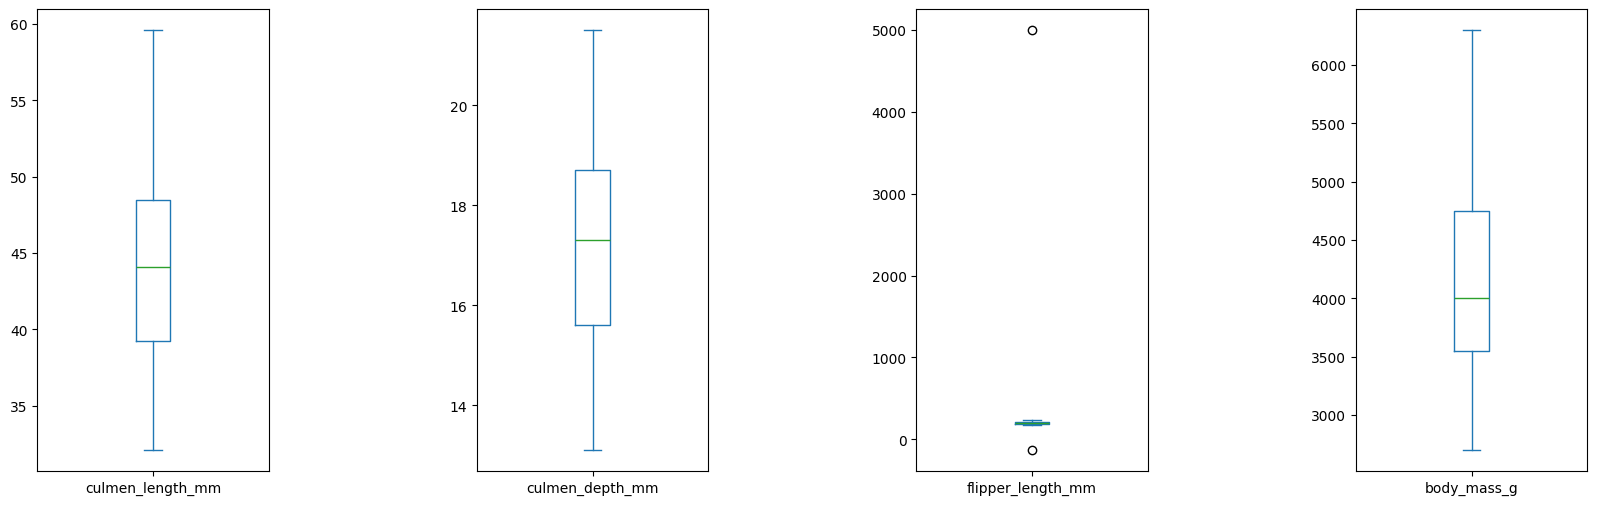

In [29]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

В столбцах 'Annual Income', 'Previous Claims', 'Premium Amount' можно заметить выбросы. Избавимся от них

In [13]:
def RemoveOutliers(df, column):
    # убираем выбросы
    Q3 = np.quantile(df[column], 0.75, axis=0)
    Q1 = np.quantile(df[column], 0.25, axis=0)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    df[column] = np.where((df[column] > upper), upper, df[column])
    df[column] = np.where((df[column] < lower), lower, df[column])
    return df

In [14]:
for col in ['flipper_length_mm']:
    train_df = RemoveOutliers(train_df, col)

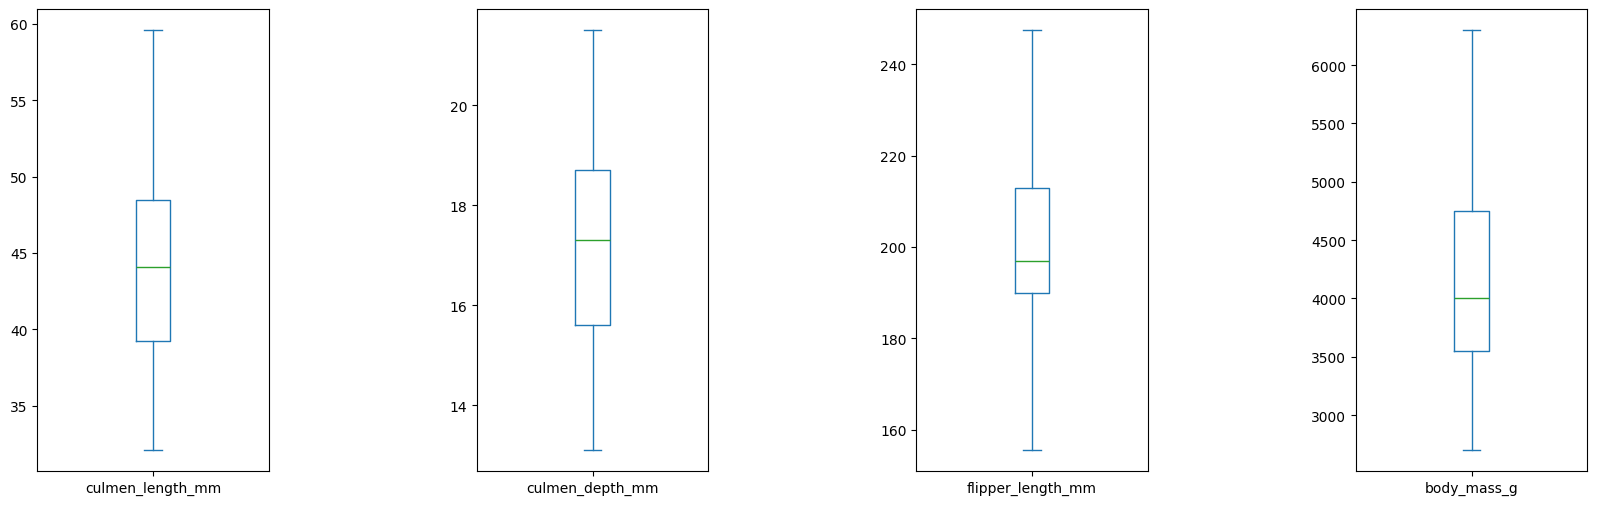

In [62]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
    figsize= (20,6)
)
plt.subplots_adjust(wspace=0.9)
plt.show()

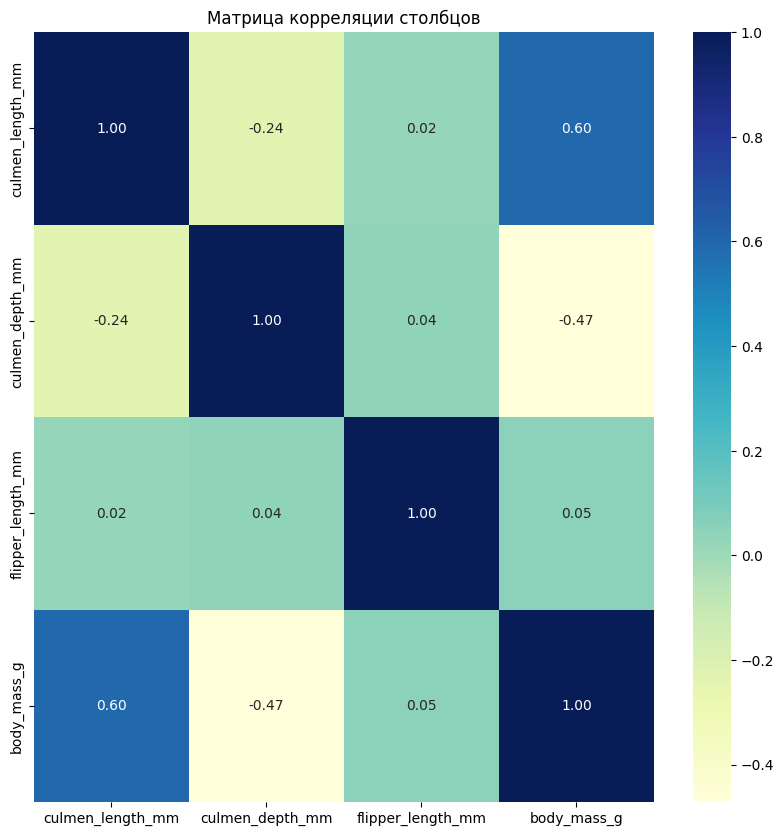

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(train_df_num.corr(), cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Матрица корреляции столбцов")
plt.show()

Нет необходимости какой-либо из столбцов удалять.

# Подготовка датасета

Закодируем категориальные переменные

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
sex = encoder.fit_transform(train_df['sex'])
encoded_df = train_df.drop("sex", axis=1)
encoded_df['sex'] = sex
encoded_df

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.70,181.00,"3,750.00",1
1,39.50,17.40,186.00,"3,800.00",0
2,40.30,18.00,195.00,"3,250.00",0
3,41.10,17.00,190.00,"3,800.00",1
4,36.70,19.30,193.00,"3,450.00",0
...,...,...,...,...,...
339,41.10,17.00,190.00,"3,800.00",1
340,46.80,14.30,215.00,"4,850.00",0
341,50.40,15.70,222.00,"5,750.00",1
342,45.20,14.80,212.00,"5,200.00",0


In [ ]:
encoded_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float64
 1   culmen_depth_mm    343 non-null    float64
 2   flipper_length_mm  343 non-null    float64
 3   body_mass_g        343 non-null    float64
 4   sex                343 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 16.1 KB


Уменьшим размерность датафрейма.

In [16]:
int_cols = encoded_df.select_dtypes('int').columns

float_cols = encoded_df.select_dtypes('float').columns
for col in int_cols:
    encoded_df[col] = pd.to_numeric(encoded_df[col], downcast='integer')
for col in float_cols:
    encoded_df[col] = pd.to_numeric(encoded_df[col], downcast='float')

In [170]:
encoded_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   343 non-null    float32
 1   culmen_depth_mm    343 non-null    float32
 2   flipper_length_mm  343 non-null    float32
 3   body_mass_g        343 non-null    float32
 4   sex                343 non-null    int8   
dtypes: float32(4), int8(1)
memory usage: 8.4 KB


Нормализируем данные

In [17]:
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
df_scaled = pd.DataFrame(Scaler.fit_transform(encoded_df), columns=encoded_df.columns)
df_scaled

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,-0.88,0.79,-1.37,-0.56,0.96
1,-0.81,0.12,-1.03,-0.50,-1.04
2,-0.66,0.43,-0.41,-1.19,-1.04
3,-0.51,-0.08,-0.75,-0.50,0.96
4,-1.32,1.09,-0.54,-0.94,-1.04
...,...,...,...,...,...
338,-0.51,-0.08,-0.75,-0.50,0.96
339,0.53,-1.45,0.98,0.82,-1.04
340,1.19,-0.74,1.46,1.94,0.96
341,0.24,-1.20,0.77,1.25,-1.04


# Примените метод снижения размерности KernelPCA

In [18]:
# словарь для хранения результатов снижения с разными ядрами
kpca_graph = {}

In [19]:
# n_components = 2 для того, чтобы можно было вывести на 2D графике
for ker in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
    kpca_graph[ker] = KernelPCA(n_components=2, kernel=ker).fit_transform(df_scaled)
kpca_graph

{'linear': array([[-1.5557009e+00,  1.1590014e+00],
        [-1.4929136e+00, -7.6266474e-01],
        [-1.5588007e+00, -6.3651788e-01],
        [-7.0665342e-01,  6.1419594e-01],
        [-2.0308239e+00, -2.9513675e-01],
        [-1.5853846e+00,  1.7238891e+00],
        [-1.9289173e+00, -6.3284677e-01],
        [-5.1721764e-01,  1.4384013e+00],
        [-1.6050944e+00,  7.1861607e-01],
        [ 1.3661540e+00,  1.3721119e+00],
        [-1.5087719e+00,  5.3431773e-01],
        [-1.4994229e+00,  6.6475922e-01],
        [-1.9612820e+00, -6.6796881e-01],
        [-1.6060480e+00,  1.9032977e+00],
        [-2.8963854e+00,  2.0064335e+00],
        [-1.9187208e+00, -7.2155964e-01],
        [-1.7298337e+00, -3.4426171e-01],
        [-4.6723843e-01,  1.8732623e+00],
        [-2.5094519e+00, -6.1375481e-01],
        [-6.2937307e-01,  2.2373736e+00],
        [-2.5374269e+00, -4.7715732e-01],
        [-1.8185548e+00,  1.1115557e+00],
        [-1.9952657e+00, -3.0267611e-01],
        [-1.2354361e+00,

# Вывод графиков

Разделим данные на два класса по столбцу sex(MALE, Female). С помощью разделения увидим сохраняется ли четкое разделение данных после понижение размерности.

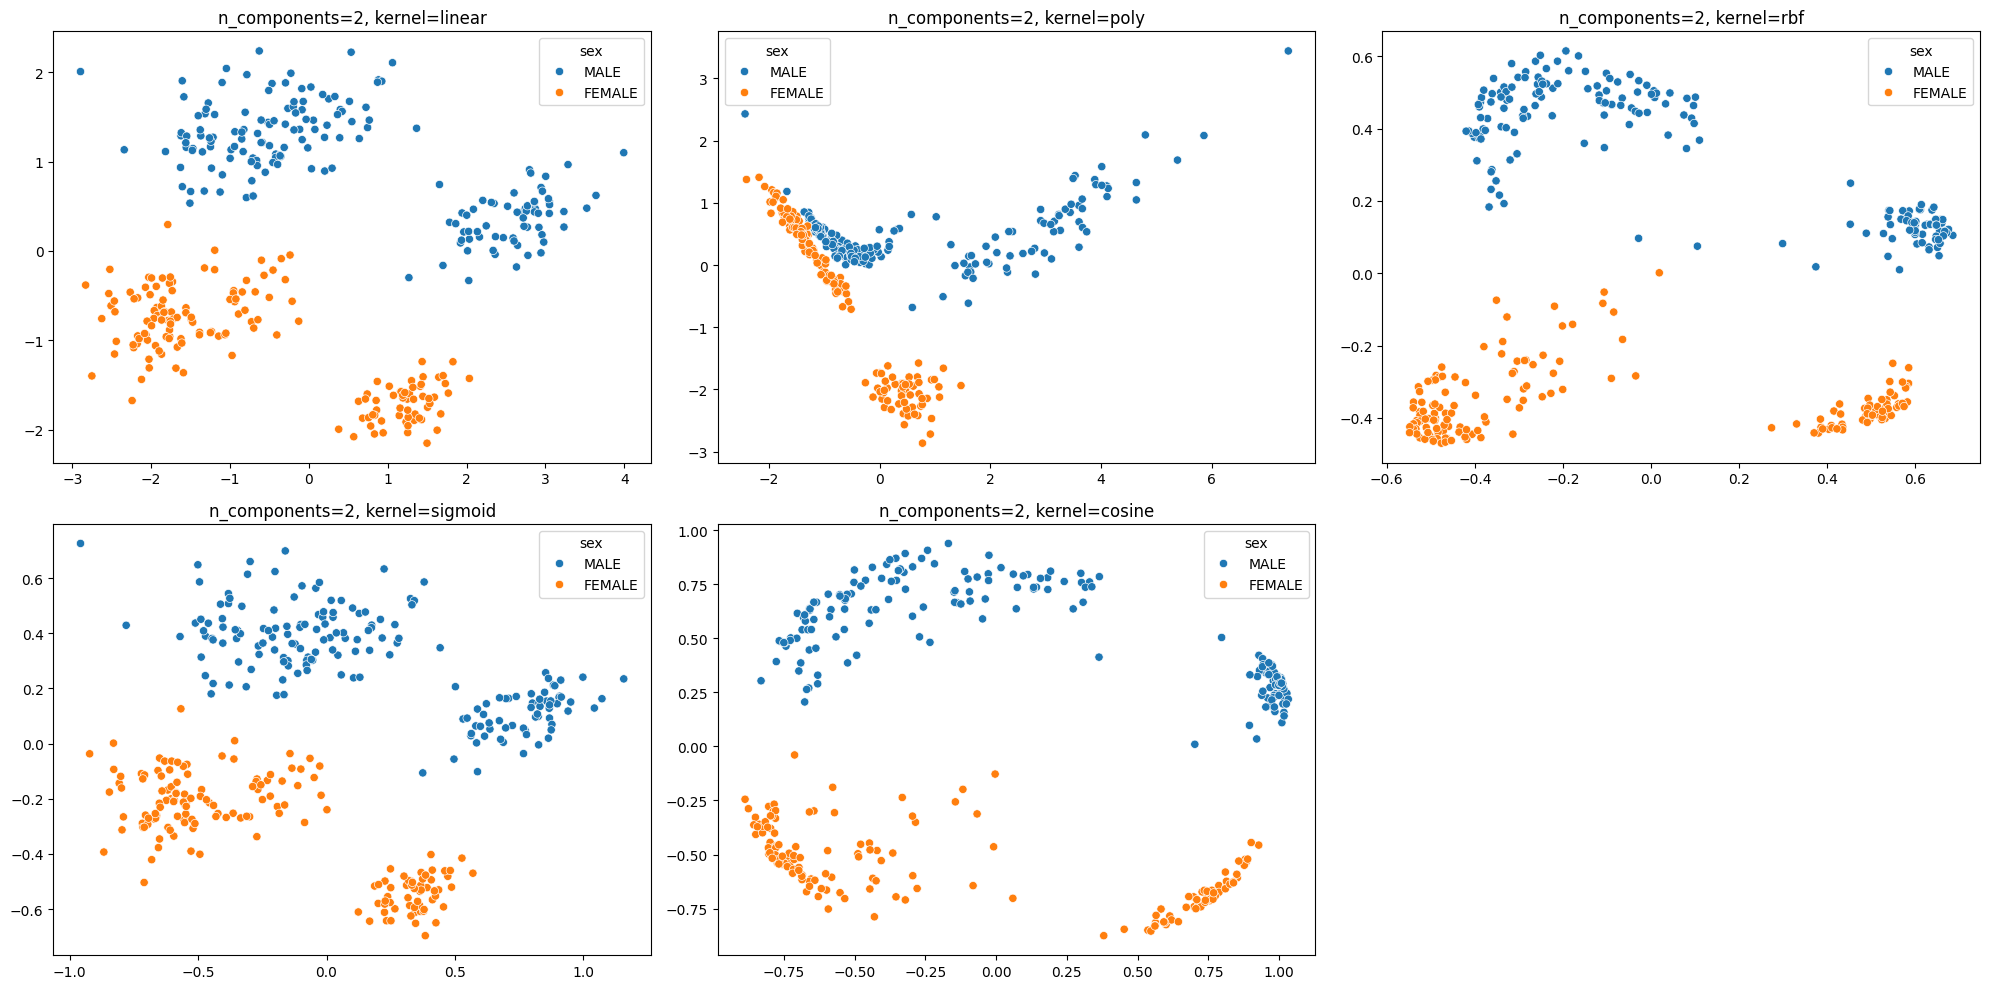

In [20]:
fig,axes = plt.subplots(2,3, figsize=(20,10))
# сразу удаляем лишний подграф
fig.delaxes(axes[1][2])
for ax, key in zip(axes.flatten(), kpca_graph.keys()):
    sns.scatterplot(x=kpca_graph[key][:,0],
                        y=kpca_graph[key][:,1],
                        hue=train_df['sex'],
                        ax=ax)
    ax.set_title(f"n_components=2, kernel={key}")
plt.tight_layout()
plt.show()

Алгорим с ядром poly не сохраняет четкого разделения по классам.

Остальные алгоритмы лучше справляются с сохранением визуально отличимых классов.

Посмотрим как понижение размерности повлияет на качество модели SVR на этих данных.

Возмем столбец body_mass_g за целевую переменную.

In [73]:
RAND_STATE = 42

Сначала построим регрессю данных без понижения размерности. 

In [74]:
X = df_scaled.drop('body_mass_g', axis=1)
Y = df_scaled['body_mass_g']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state = RAND_STATE)

In [76]:
# словарь для оценок качества моделей
regression_error = {}

In [78]:
svr = SVR()
svr.fit(X_train, y_train)
Y_pred_test = svr.predict(X_test)
regression_error['SVR'] = {"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [79]:
regression_error['SVR']

{'RMSE': 0.38988375671046427,
 'MSE': 0.1520093437466645,
 'MAE': 0.3101768383912953}

Теперь понизим измерения X с помощью KernelPCA с разными ядрами.

In [80]:
X_kpca = {}

In [81]:
for ker in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
    X_kpca[ker] = KernelPCA(n_components=2, kernel=ker).fit_transform(X)
X_kpca

{'linear': array([[ 1.5918125 ,  1.0212905 ],
        [ 1.3915774 , -0.8901146 ],
        [ 1.028672  , -0.683253  ],
        [ 0.5872325 ,  0.57741004],
        [ 1.7950536 , -0.44102225],
        [ 1.5832273 ,  1.5993962 ],
        [ 1.7735146 , -0.7875931 ],
        [ 1.1421754 ,  1.2826704 ],
        [ 1.4438612 ,  0.60279053],
        [-1.4226015 ,  1.5205828 ],
        [ 1.1450887 ,  0.4684238 ],
        [ 1.463954  ,  0.5374079 ],
        [ 1.4480203 , -0.7535393 ],
        [ 1.746277  ,  1.7508745 ],
        [ 3.7739675 ,  1.5910681 ],
        [ 1.8365362 , -0.8937155 ],
        [ 1.4229103 , -0.4476286 ],
        [ 0.9435936 ,  1.7612495 ],
        [ 2.2513196 , -0.8054402 ],
        [ 0.885185  ,  2.1633735 ],
        [ 2.3226237 , -0.6738196 ],
        [ 1.7871547 ,  0.96117127],
        [ 2.0410533 , -0.50148904],
        [ 1.3712611 ,  0.7930982 ],
        [ 1.3347472 ,  0.5506996 ],
        [ 2.1296246 , -0.6169533 ],
        [ 1.3177558 ,  1.0539117 ],
        [ 1.350600

In [82]:
for ker, X in X_kpca.items():
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.3, random_state = RAND_STATE)
    svr = SVR()
    svr.fit(X_train, y_train)
    Y_pred_test = svr.predict(X_test)
    regression_error[f'SVR PCA-{ker}'] = {"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [83]:
pd.options.display.float_format = '{:,.5f}'.format
regression_error_df = pd.DataFrame(regression_error)
regression_error_df

,SVR,SVR PCA-linear,SVR PCA-poly,SVR PCA-rbf,SVR PCA-sigmoid,SVR PCA-cosine
RMSE,0.38988,0.39959,0.42642,0.41148,0.40149,0.38165
MSE,0.15201,0.15968,0.18183,0.16931,0.16119,0.14566
MAE,0.31018,0.31926,0.33916,0.32251,0.32137,0.30054


Можно увидеть, что лучше всего себя показала модель KernelPCA с ядром cosine.

# Для линейного ядра 

In [185]:
pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(df_scaled)

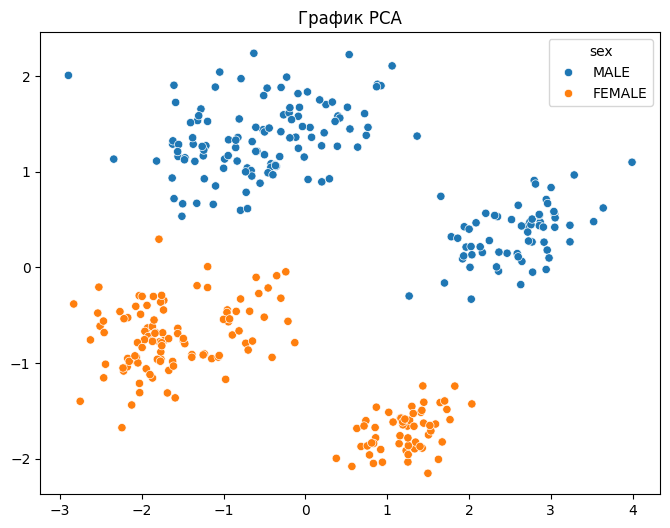

In [ ]:
# Построение графика
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data_pca[:,0],
                        y=reduced_data_pca[:,1],
                        hue=train_df['sex'])
plt.title('График PCA')
plt.show()

In [192]:
# Расчет сохраненной и потерянной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
total_explained_variance = np.sum(explained_variance_ratio)
lost_variance = 1 - total_explained_variance
print("Доля потерянной дисперсии(lost_variance): ", lost_variance)
print("Доля обьясненной дисперсии(total_explained_variance): ", total_explained_variance)

Доля потерянной дисперсии(lost_variance):  0.16268021
Доля обьясненной дисперсии(total_explained_variance):  0.8373198


Два компонента объясняют около 83.73% вариации данных

Оставшиеся 16.26% информации теряются при уменьшении размерности

Так как сохранятся более 80% дисперсии в данных, можно считать, что алгоритм с линейным ядром справляется с задачей снижения размерности

# TSNE

In [43]:
from sklearn.manifold import TSNE
df_embedded = TSNE(n_components=2).fit_transform(df_scaled)

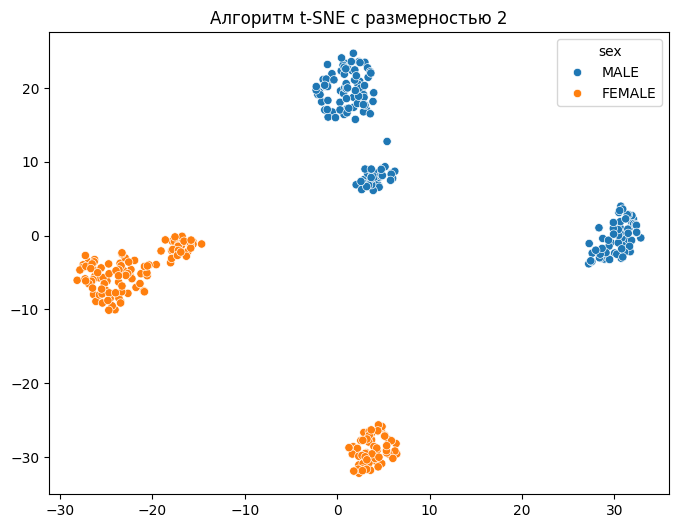

In [44]:
# Построение графика
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_embedded[:,0],
                        y=df_embedded[:,1],
                        hue=train_df['sex'])
plt.title('Алгоритм t-SNE с размерностью 2')
plt.show()

Алгоритм t-SNE скомпановал и разделил данные лучше предыдуших алгоритмов. На графике можно четко отделить точки по группам.

Попробуем посмотреть качество дерева регрессии с алгоритмом TSNE.

In [84]:
X_TSNE = TSNE(n_components=2).fit_transform(X)
X_TSNE

array([[-20.740707  ,   9.9555025 ],
       [ -5.787678  , -22.027359  ],
       [ -4.25466   , -21.339727  ],
       [-17.04474   ,   8.930881  ],
       [-10.238243  , -17.103016  ],
       [-18.568024  ,  11.945054  ],
       [ -8.78275   , -19.217836  ],
       [-17.033749  ,  11.979708  ],
       [-20.235897  ,   8.175942  ],
       [ -3.4936135 ,  17.26885   ],
       [-20.080809  ,   8.077195  ],
       [-20.45441   ,   8.189116  ],
       [ -6.791258  , -20.033333  ],
       [-18.631248  ,  11.671334  ],
       [-21.420866  ,   8.856869  ],
       [ -8.505931  , -19.492779  ],
       [ -9.496614  , -17.37237   ],
       [-13.949744  ,  13.149742  ],
       [-10.19092   , -18.278145  ],
       [-13.02582   ,  13.9412155 ],
       [-10.582814  , -17.97403   ],
       [-21.024612  ,   9.37101   ],
       [-10.558298  , -17.336761  ],
       [-20.462816  ,   9.381104  ],
       [-20.29001   ,   8.142014  ],
       [-10.534649  , -17.753572  ],
       [-19.646727  ,  10.621355  ],
 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_TSNE, Y, train_size=0.3, random_state = RAND_STATE)
svr = SVR()
svr.fit(X_train, y_train)
Y_pred_test = svr.predict(X_test)
regression_error[f'SVR TSNE'] = {"RMSE":root_mean_squared_error(y_test, Y_pred_test),"MSE":mean_squared_error(y_test, Y_pred_test), "MAE": mean_absolute_error(y_test, Y_pred_test)}

In [86]:
pd.options.display.float_format = '{:,.5f}'.format
regression_error_df = pd.DataFrame(regression_error)
regression_error_df

,SVR,SVR PCA-linear,SVR PCA-poly,SVR PCA-rbf,SVR PCA-sigmoid,SVR PCA-cosine,SVR TSNE
RMSE,0.38988,0.39959,0.42642,0.41148,0.40149,0.38165,0.40731
MSE,0.15201,0.15968,0.18183,0.16931,0.16119,0.14566,0.16590
MAE,0.31018,0.31926,0.33916,0.32251,0.32137,0.30054,0.31929


В нашем случае TSNE проявил себя чуть хуже KernelPCA с ядром cosine и SVR с данными без понижения размерности.